# regression example - house price dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import dill
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from xgboost import XGBRegressor
import treelite
import treelite_runtime
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
cmap = sns.color_palette("viridis", as_cmap=True)
cmap = sns.color_palette("vlag", as_cmap=True)

**Gators** imports

In [4]:
from gators.util import util
# sampling
from gators.sampling import UnsupervisedSampling
# data cleaninng
from gators.data_cleaning import (
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    WOEEncoder, 
    TargetEncoder,
    OrdinalEncoder, 
)
# binning
from gators.binning import (
    BinRareCategories,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
    PolynomialFeatures,
    PolynomialObjectFeatures,
)
# feature selection
from gators.feature_selection import (
    InformationValue,
    SelectFromModel,
)
# model building
from gators.model_building import (
    TrainTestSplit,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
    LGBMTreeliteDumper,
)
# # pipeline
from gators.pipeline import Pipeline

## data analysis

In [5]:
data = pd.read_parquet('data/house_prices.parquet').reset_index(drop=True)
y = data['SalePrice']
y = y.astype(float)
X = data.drop('SalePrice', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

In [6]:
X_train.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal


,count,mean,std,min,25%,50%,75%,max
SalePrice,1022.0,181713.254403,79854.663341,34900.0,130000.0,163745.0,214975.0,755000.0


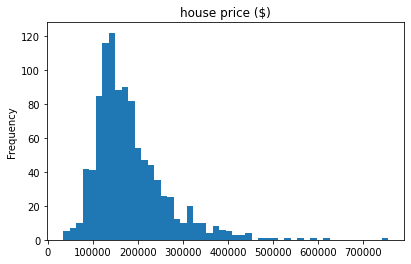

In [7]:
y_train.plot(
    kind='hist', 
    figsize=(4*1.6, 4),
    title='house price ($)',
    bins=50) ;
pd.DataFrame(y_train.describe()).T

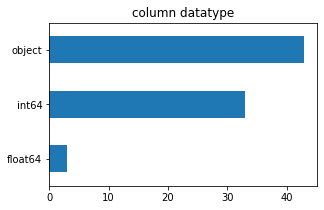

In [8]:
X_train.dtypes.value_counts(ascending=True).plot(
    figsize=(3*1.6, 3), 
    title='column datatype',
    kind='barh');

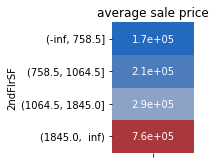

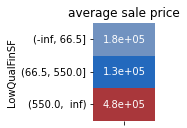

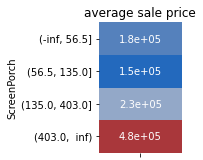

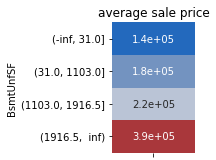

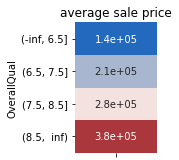

In [9]:
steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.05)),
    ('DropLowCardinality', DropLowCardinality(min_categories=2)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=0)),
    ('TreeBinning', TreeBinning(
        tree=DecisionTreeRegressor(max_depth=2, min_samples_split=50), inplace=True)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('TargetEncoder', TargetEncoder(add_missing_categories=False)),
]
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)
figs = pipe.display_encoder_mapping(cmap=cmap, decimals=0, describe='average sale price')

## offline pipeline - feature selection

In [10]:
k = 30
model = XGBRegressor(random_state=0, objective='reg:squarederror')
steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('OrdinalEncoder', OrdinalEncoder()),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=0)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('SelectFromModel', SelectFromModel(model=model, k=k)),
]

In [11]:
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)

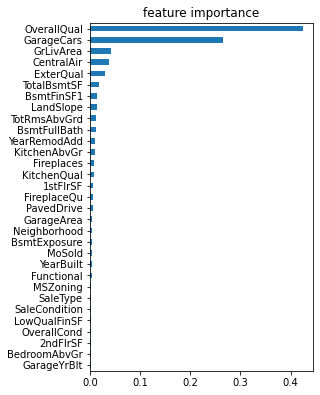

In [12]:
pipe.steps[-1][1].feature_importances_.iloc[k::-1].plot(
    kind='barh', 
    figsize=(4, 4*1.6), 
    title='feature importance',
);

In [13]:
selected_columns = pipe.steps[-1][1].selected_columns
polynomial_columns = pipe.steps[-1][1].feature_importances_.index[:5]

## pipeline optimization

In [14]:
model = XGBRegressor(random_state=0, objective='reg:squarederror', max_depth=2)

steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=-1)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('TargetEncoder', TargetEncoder(add_missing_categories=True)),
    ('ESTIMATOR', model),
]

param_distributions = {
    "BinRareCategories__min_ratio": [0.05, 0.1, 0.2],
    "NumericsImputer__strategy": ["mean", "constant"],
    "ObjectImputer__strategy": ["constant", "most_frequent"],
    'ESTIMATOR__subsample': [0.5, 0.6, 0.7],
    'ESTIMATOR__colsample_bytree': [0.4, 0.5, 0.6],
    'ESTIMATOR__min_child_weight': [10, 20, 30],
}
scoring = make_scorer(mean_absolute_error)

cv = KFold(n_splits=10, random_state=0, shuffle=True)
pipe = Pipeline(steps=steps, verbose=False)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions, 
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=0,
    verbose=True)
_ = search.fit(X_train.copy(), y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [15]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(random_state=0, max_depth=2)

steps = [
    ('BinRareCategories', BinRareCategories(min_ratio=0.1)),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('NumericsImputer', NumericsImputer(strategy='constant', value=-1)),
    ('CleanCategories', BinRareCategories(min_ratio=0.0)),
    ('TargetEncoder', TargetEncoder(add_missing_categories=True)),
    ('ESTIMATOR', model),
]

param_distributions = {
    "BinRareCategories__min_ratio": [0.05, 0.1, 0.2],
    "NumericsImputer__strategy": ["mean", "constant"],
    "ObjectImputer__strategy": ["constant", "most_frequent"],
    'ESTIMATOR__subsample': [0.5, 0.6, 0.7],
    'ESTIMATOR__colsample_bytree': [0.4, 0.5, 0.6],
    'ESTIMATOR__min_child_weight': [10, 20, 30],
}
scoring = make_scorer(mean_absolute_error)

cv = KFold(n_splits=10, random_state=0, shuffle=True)
pipe = Pipeline(steps=steps, verbose=False)
# pipe.fit(X_train[selected_columns].copy(), y_train)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions, 
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    verbose=True,
    pre_dispatch=5)
_ = search.fit(X_train[selected_columns].copy(), y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [16]:
columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score', 'rank_test_score']
pd.DataFrame(search.cv_results_)[columns].sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score
29,0.755303,0.031102,0.045739,0.001519,0.884753,0.045445,1
25,0.666484,0.009257,0.044689,0.000652,0.884753,0.045445,1
18,0.672671,0.019969,0.044349,0.001348,0.884753,0.045445,1
11,0.697875,0.011188,0.045878,0.001566,0.884753,0.045445,1
27,0.712112,0.039120,0.048250,0.004245,0.884021,0.046108,5


## model evaluation

In [17]:
train_error = mean_absolute_error(
    y_train, search.best_estimator_.predict(X_train[selected_columns]))
print(f'mean absolute error - train set: {round(train_error)}')
test_error = mean_absolute_error(
    y_test, search.best_estimator_.predict(X_test[selected_columns]))
print(f'mean absolute error - test set: {round(test_error)}')

mean absolute error - train set: 14740
mean absolute error - test set: 18647


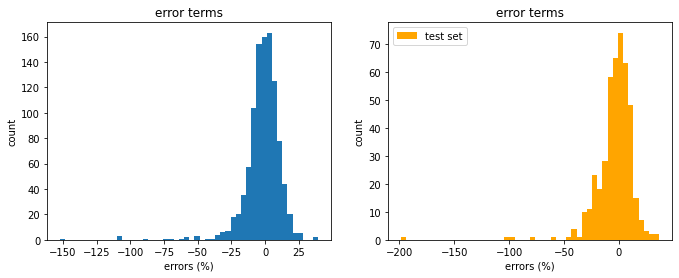

In [18]:
train_errors = 100 * (y_train - search.best_estimator_.predict(X_train[selected_columns])) / y_train
test_errors = 100 * (y_test - search.best_estimator_.predict(X_test[selected_columns])) / y_test
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 2, figsize=[7 *1.6, 4]);
ax[0].hist(train_errors, bins=50, label='train set');
ax[0].set_title('error terms');
ax[0].set_xlabel('errors (%)');
ax[0].set_ylabel('count');
ax[1].hist(test_errors, bins=50, label='test set', color='orange');
ax[1].set_title('error terms');
ax[1].set_xlabel('errors (%)');
ax[1].set_ylabel('count');
plt.legend();

## production pipeline & model

In [19]:
prod_pipe = copy.deepcopy(search.best_estimator_)
_ = prod_pipe.steps.pop(-1)
model_pd = copy.deepcopy(search.best_estimator_.steps[-1][1])

In [20]:
X_train_prepro_np = prod_pipe.transform_numpy(X_train[selected_columns].to_numpy())
y_train_np = y_train.to_numpy()

In [21]:
LGBMTreeliteDumper().dump(
    model=model_pd, 
    toolchain='gcc',
    parallel_comp=4,
    model_path='./models/', 
    model_name='treelite_lgbm_house')

model_prod = treelite_runtime.Predictor(
    './models/treelite_lgbm_house.so', verbose=False)

[16:30:53] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[16:30:54] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.


In [22]:
X_test_np = X_test[selected_columns].to_numpy()
y_pred_pd = model_pd.predict(
    prod_pipe.transform(X_test[selected_columns].copy()))
y_pred_tl = model_prod.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_test_np.copy()
        )
    )
)

### check if Pandas & Treelite predictions match

In [23]:
assert np.allclose(y_pred_pd, y_pred_tl)

## per-sample bechmarking

### pipeline only

In [24]:
x = X_test[selected_columns].iloc[[1]]
xnp = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(xnp.copy())

26.4 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.7 µs ± 160 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x2079'

### pipeline & model

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x).copy())[0]
stats_tl = %timeit -o  model_prod.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(xnp.copy())))

31.1 ms ± 902 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.9 µs ± 609 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x577'

/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` i

/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` i

/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` i

/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` i

/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` i

/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` is not needed
  `NumericsImputer` is not needed"""
/Users/cpoli/opensource/gators/gators/imputers/numerics_imputer.py:142: UserWarning: `X` does not contain numerical columns,
                `NumericsImputer` i